In [126]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV

# Arreglo de datos

In [58]:
base_raw = pd.read_csv('data/P00533/P00533_03_ligands_smiles_activity_type.csv')
base_raw.activity_type.value_counts()

Inactive        4181
Active          1854
Intermediate    1282
Name: activity_type, dtype: int64

<AxesSubplot:>

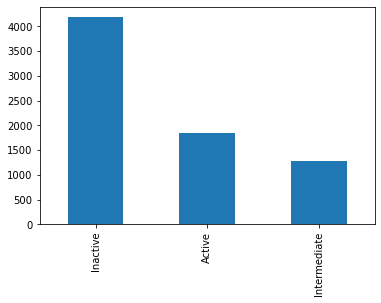

In [59]:
base_raw.activity_type.value_counts().plot.bar(x='activity_type')

<AxesSubplot:>

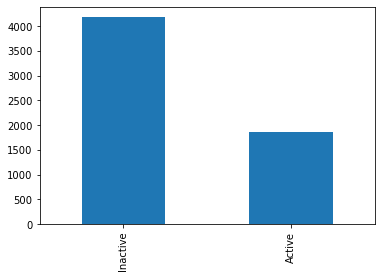

In [63]:
bd = base_raw[base_raw['activity_type'] != 'Intermediate'].drop(['chembl_id_ligand'], axis=1)
bd.activity_type.value_counts().plot.bar(x='activity_type')

In [64]:
bd['activity'] = 0
bd.loc[bd[bd.activity_type == 'Active'].index, 'activity'] = 1.0
bd.drop(['activity_type'], axis=1, inplace=True)
print(len(bd))
bd.head()

6035


,smiles,activity
0,Brc1cccc(Nc2ncnc3c2sc2ccccc23)c1,1
1,Brc1cccc(Nc2ncnc3cc(NCCCCN4CCOCC4)ncc23)c1,1
2,Brc1cccc(Nc2ncnc3cc(NCCCN4CCOCC4)ncc23)c1,1
3,Brc1cccc(Nc2ncnc3cc(NCCCn4ccnc4)ncc23)c1,1
4,Brc1cccc(Nc2ncnc3cc(NCCN4CCOCC4)ncc23)c1,1


In [65]:
bd['morgan2_c'] = bd.smiles.map(lambda smile: rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2).ToList())
bd = bd[['morgan2_c', 'activity']]
bd.head()

,morgan2_c,activity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [85]:
fp_df_train, fp_df_valid = train_test_split(bd, test_size=0.3, random_state=142857, shuffle=True, stratify=bd['activity'])
fp_df_train.reset_index(drop=True, inplace=True)
fp_df_valid.reset_index(drop=True, inplace=True)
print(len(fp_df_train), len(fp_df_valid))
fp_df_train.head()

4224 1811


,morgan2_c,activity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


# Entrenar el modelo

In [113]:
X, y = fp_df_train.morgan2_c, fp_df_train.activity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142857, shuffle=True, stratify=y)
X_train, X_test = X_train.tolist(), X_test.tolist()

In [140]:
model = RandomForestClassifier()
params_dict = model.get_params(deep=True)
print(params_dict) # parametros por defecto
model.fit(X_train, y_train)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


RandomForestClassifier()

In [141]:
# Conjunto de entrenamiento
y_predict = model.predict(X_train)
acc_train = accuracy_score(y_train, y_predict)
# Conjunto de test
y_predict_test = model.predict(X_test)
acc_test = accuracy_score(y_test, y_predict_test)
print(acc_train, acc_test)

0.9991121633619414 0.9183431952662722


# Grid Search CV (BayesSearchCV)

In [134]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': [None, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_features': [0.2, 0.3, 0.4, 0.5, 0.6],
    'max_leaf_nodes': [None, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_samples': [0.6, 0.7, 0.8, 0.9, 1]}

model = RandomForestClassifier()
clf = BayesSearchCV(estimator=model, search_spaces=param_grid, cv=5, n_iter=20, n_jobs=-1,
                    scoring='accuracy', refit=True, return_train_score=True, verbose=3,
                    random_state=142857)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
              random_state=142857, return_train_score=True, scoring='accuracy',
              search_spaces={'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 5, 6, 7, 8, 9, 10, 11, 12],
                             'max_features': [0.2, 0.3, 0.4, 0.5, 0.6],
                             'max_leaf_nodes': [None, 5, 6, 7, 8, 9, 10, 11,
                                                12],
                             'max_samples': [0.6, 0.7, 0.8, 0.9, 1]},
              verbose=3)

In [135]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_max_samples,params,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,rank_train_score
0,6.167751,0.062977,0.076410,0.011401,gini,11,0.3,9,1.0,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",...,0.013102,15,0.850906,0.870514,0.853496,0.850906,0.862426,0.857650,0.007701,13
1,5.834425,0.104414,0.067388,0.005103,gini,8,0.4,6,0.8,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",...,0.013544,19,0.833888,0.829819,0.834628,0.832408,0.831361,0.832421,0.001727,19
2,3.950781,0.112610,0.065149,0.004218,entropy,10,0.3,9,0.6,"{'criterion': 'entropy', 'max_depth': 10, 'max...",...,0.010659,16,0.840548,0.850166,0.844247,0.845727,0.844675,0.845073,0.003088,16
3,3.644486,0.087909,0.065116,0.005406,gini,11,0.2,5,1.0,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",...,0.007187,20,0.828339,0.818720,0.830189,0.829819,0.825074,0.826428,0.004255,20
4,5.990474,0.048751,0.069116,0.005059,gini,5,0.4,12,0.7,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",...,0.005668,11,0.870514,0.875324,0.868294,0.876064,0.874260,0.872891,0.002988,10
5,2.983734,0.043602,0.069292,0.007684,log_loss,5,0.2,9,0.7,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",...,0.011102,16,0.843507,0.853496,0.840917,0.846097,0.839867,0.844777,0.004866,17
6,9.268007,0.140787,0.094065,0.009086,entropy,11,0.6,11,0.7,"{'criterion': 'entropy', 'max_depth': 11, 'max...",...,0.012454,10,0.867555,0.871624,0.862005,0.864965,0.869453,0.867120,0.003368,11
7,15.807128,0.206966,0.115059,0.063796,gini,10,0.6,None,0.8,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",...,0.004094,3,0.948946,0.955235,0.950425,0.954125,0.950444,0.951835,0.002411,6
8,5.273121,0.127878,0.075568,0.023772,gini,10,0.4,9,0.6,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",...,0.011319,13,0.857196,0.870884,0.846467,0.859415,0.864645,0.859721,0.008136,12
9,12.616634,0.151871,0.077906,0.017383,gini,9,0.6,None,0.6,"{'criterion': 'gini', 'max_depth': 9, 'max_fea...",...,0.005618,7,0.936367,0.948206,0.934517,0.936367,0.941568,0.939405,0.004990,9


In [138]:
parametros_optimizados = clf.best_params_
parametros_optimizados

OrderedDict([('criterion', 'log_loss'),
             ('max_depth', 11),
             ('max_features', 0.6),
             ('max_leaf_nodes', None),
             ('max_samples', 0.7)])

In [142]:
# Conjunto de entrenamiento
y_predict = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_predict)
# Conjunto de test
y_predict_test = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_predict_test)
print(acc_train, acc_test)

0.963894643385617 0.8982248520710059


In [145]:

model = RandomForestClassifier(**parametros_optimizados)
params_dict = model.get_params(deep=True)
# print(params_dict) # parametros por defecto
model.fit(X_train, y_train)
# Conjunto de entrenamiento
y_predict = model.predict(X_train)
acc_train = accuracy_score(y_train, y_predict)
# Conjunto de test
y_predict_test = model.predict(X_test)
acc_test = accuracy_score(y_test, y_predict_test)
print(acc_train, acc_test)

0.9650784255696951 0.8946745562130177
